# Doc 10.1 - Transfer Learning com DenseNet com congelamento geral e downscale 4x com data augmentation nas classes minoritárias

Vamos nessa documentação ver como um data augmentation nas classes minoritárias afetaria o aprendizado da rede.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns
import cv2
import matplotlib.image as mpimg

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 - Visualização da base de dados

In [2]:
#Função para visualização
def plot_image_counts(folder_path):
    #Contadores pra plotar
    counts = {'actionable': 0, 'benign': 0, 'cancer': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

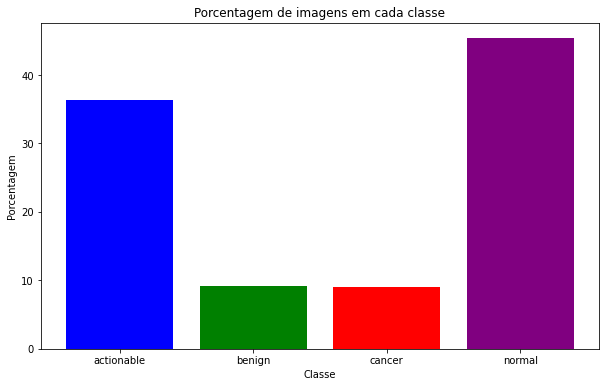

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         240    36.308623
benign              61     9.228442
cancer              60     9.077156
normal             300    45.385779


In [3]:
#Test set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\test'
plot_image_counts(folder_path)

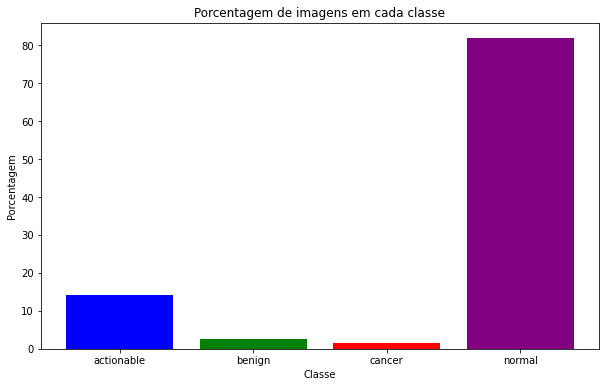

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         712    14.180442
benign             124     2.469628
cancer              76     1.513643
normal            4109    81.836288


In [4]:
#Training set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\train'
plot_image_counts(folder_path)

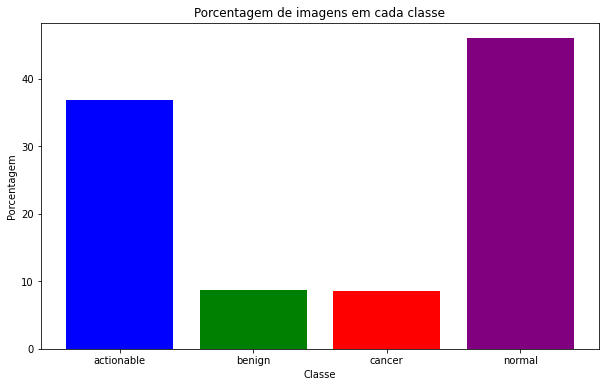

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         160    36.781609
benign              38     8.735632
cancer              37     8.505747
normal             200    45.977011


In [5]:
#Validation set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\val'
plot_image_counts(folder_path)

# 2 - Data augmentation

In [10]:
#Função para data augmentation
def augment_images(image_folder):
    images = os.listdir(image_folder)
    for image_name in images:
        image_path = os.path.join(image_folder, image_name)
        #Pega a imagem
        image = cv2.imread(image_path)
        if image is None:
            continue 
        
        #Adiciona ruído
        noise = np.random.normal(loc=0, scale=25, size=image.shape)
        noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
        
        #Flip horizontal
        flipped_horizontal = cv2.flip(image, 1)
        
        #Flip vertical
        flipped_vertical = cv2.flip(image, 0)
        
        #Salva as imagens
        noise_path = os.path.join(image_folder, "aug_noise_" + image_name)
        horizontal_path = os.path.join(image_folder, "aug_horizontal_" + image_name)
        vertical_path = os.path.join(image_folder, "aug_vertical_" + image_name)
        
        cv2.imwrite(noise_path, noisy_image)
        cv2.imwrite(horizontal_path, flipped_horizontal)
        cv2.imwrite(vertical_path, flipped_vertical)

target_folder = r"D:\Coisinhas\Coisas_UNB\TCC\resized_and_augmentedCV2" #Copiei as imagens do resized_paper_dataset para esse

#Aplicação do data augmentation nas classes minoritarias
train_folder = os.path.join(target_folder, "train")
for category in ["actionable", "benign", "cancer"]:
    category_folder = os.path.join(train_folder, category)
    if os.path.exists(category_folder):
        augment_images(category_folder)

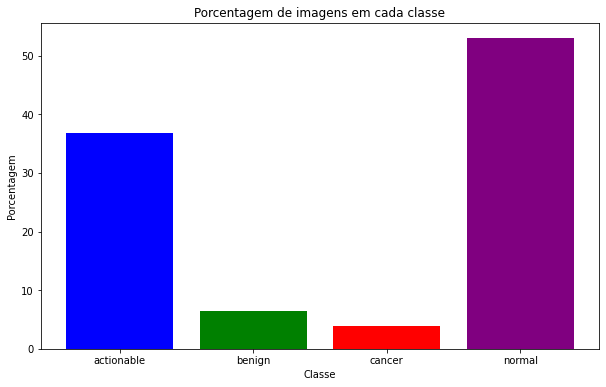

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable        2848    36.715225
benign             496     6.394225
cancer             304     3.919041
normal            4109    52.971510


In [11]:
#Training set augmented
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_and_augmentedCV2\train'
plot_image_counts(folder_path)

Apliquei um augmentation "simples", fazendo flip vertical e horizontal das imagens e adicionando ruído para ver se vai melhorar os resultados da rede da documentação passada. A quantidade de benign e cancer não aumentou muito, talvez seja bom realizar uma maior quantidade de operações em cima dessas duas classes.

# 3 - Modelo usando DenseNet

In [12]:
#Diretórios
train_dir = r'D:\Coisinhas\Coisas_UNB\TCC\resized_and_augmentedCV2\train'
val_dir = r'D:\Coisinhas\Coisas_UNB\TCC\resized_and_augmentedCV2\test'
test_dir = r'D:\Coisinhas\Coisas_UNB\TCC\resized_and_augmentedCV2\val'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 16

#CLasses
num_classes = 4

In [13]:
#Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 7757 images belonging to 4 classes.
Found 661 images belonging to 4 classes.
Found 435 images belonging to 4 classes.


In [14]:
#Transfer learning com a densenet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 4 classes
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output) 
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose = 1, restore_best_weights=True)

In [17]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


C:\Users\breno\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


485/485 ━━━━━━━━━━━━━━━━━━━━ 3607s 7s/step - accuracy: 0.5311 - loss: 17.0795 - val_accuracy: 0.4554 - val_loss: 1.3531
Epoch 2/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4454s 9s/step - accuracy: 0.6978 - loss: 0.7420 - val_accuracy: 0.4660 - val_loss: 1.3479
Epoch 3/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4197s 9s/step - accuracy: 0.7287 - loss: 0.6903 - val_accuracy: 0.4448 - val_loss: 1.5387
Epoch 4/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4118s 8s/step - accuracy: 0.7562 - loss: 0.6196 - val_accuracy: 0.4599 - val_loss: 1.8573
Epoch 5/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4166s 9s/step - accuracy: 0.7900 - loss: 0.5308 - val_accuracy: 0.4221 - val_loss: 1.5035
Epoch 6/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4320s 9s/step - accuracy: 0.7904 - loss: 0.5084 - val_accuracy: 0.4236 - val_loss: 1.8234
Epoch 7/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4156s 9s/step - accuracy: 0.8371 - loss: 0.4210 - val_accuracy: 0.4675 - val_loss: 2.1785
Epoch 8/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4182s 9s/step - accuracy: 0.8511 - loss: 0.3774 - val

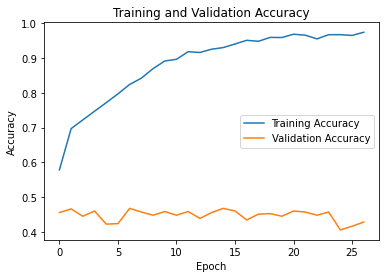

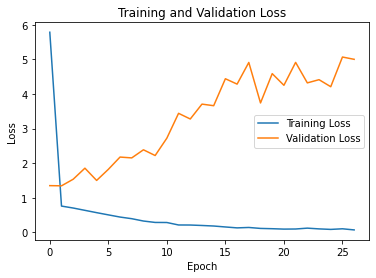

In [18]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.4672 - loss: 1.2241
Test Accuracy: 46.67%
Test Loss: 1.2255


In [20]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

28/28 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step


array([3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 0, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3, 3, 3,
       3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 3,
       0, 3, 3, 0, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3,
       0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3,
       0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3,
       3, 0, 0, 3, 3, 0, 0, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 2, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3,

In [21]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

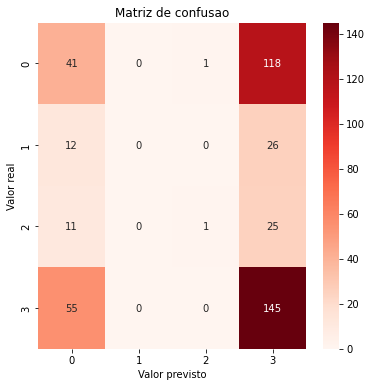

In [22]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

Podemos perceber que a quantidade de chutes em actionable aumentou, mas a rede ainda não se mostra capaz de detectar as outras duas classes.